In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

import os
os.chdir('D:\\Imperial MSc\\Electives\\Workforce Analytics\\Coursework')

%matplotlib inline

### Part 1: Read in Data & Performance Measure

In [2]:
collegeBball = pd.read_csv('college_bball_data.csv')

# Clean ampersand character
collegeBball['opp_name'] = collegeBball['opp_name'].str.replace('&amp;', '&')

# Construct Target Variable - Win/Loss Binary Outcome
collegeBball['win'] = (collegeBball['outcome'] > 0)

### Part 2: Data Enrichment (Previous Season Winning Percentage Difference & Position Diversity)

In [3]:
# (1 - Herfindahl) helper function to calculate Position Diversity Later On
def herfindahl(input_list):
    
    herf = 1
    lengthList = len(input_list)
    for element in set(input_list):
        herf -= (float(input_list.count(element)) / lengthList)**2
 
    return herf

In [4]:
years = [x for x in range(2006, 2016)]
colleges = ['Brown', 'Columbia', 'Cornell', 'Dartmouth', 'Harvard', 'Pennsylvania', 'Princeton', 'Yale']

# Read in previous season school stats, and get the previous season winning percentages for all schools (incl opponent school)
schoolStats = {}

for year in years:
    fname1 = "Data\\AdvancedSchoolStats{}.csv".format(year - 1)
    
    if os.path.isfile(fname1):
        # Skip first line - an unused header row
        stats = pd.read_csv(fname1, skiprows = 1)
        
        # Preprocess school name, remove * character        
        cleanNames = []
        for schoolnames in stats['School'].str.split('*'):
            cleanNames.append(schoolnames[0].strip())
        stats['School'] = cleanNames
        
        schoolStats[year] = stats

In [5]:
# Iterate through the data in CSV and look up the college's and opponent's previous year winning perecentages
pastWinPct = []
oppPastWinPct = []
for index, row in collegeBball.iterrows():
    year = row['Year']
    college = row['School'].capitalize() # College's name is capitalized in schoolStats dataframe
    opponent = row['opp_name']
    
    statsDF = schoolStats[year]
    collegeWinPct = float(statsDF.loc[statsDF['School'] == college, 'W-L%'])
    
    opponentWinPct = statsDF.loc[statsDF['School'] == opponent, 'W-L%']
    
    # If there is no past record for the opponent
    if len(opponentWinPct) < 1:
        opponentWinPct = 0.0
    else:
        opponentWinPct = float(opponentWinPct)
    
    pastWinPct.append(collegeWinPct)
    oppPastWinPct.append(opponentWinPct)

collegeBball['Past Win Percentage'] = pastWinPct
collegeBball['Opponent Past Win Percentage'] = oppPastWinPct
collegeBball['Past Win Percentage Diff'] = collegeBball['Past Win Percentage'] - collegeBball['Opponent Past Win Percentage']

In [6]:
# Roster data for each school has been downloaded, this portion of codes read the data and calculate position diversity
rowlist = []
for college in colleges:
    for year in years:
        
        row = [college.lower(), year] # Use lowercase college name to merge with original dataframe later
        fname1 = "Data\\{}Roster{}.csv".format(college.lower(), year)
        
        if os.path.isfile(fname1):
            roster = pd.read_csv(fname1)
            row.append(herfindahl(list(roster['Pos'])))
        
        rowlist.append(row)

# Position Diversity for each of the 8 Ivy League schools for each year
posDiversity = pd.DataFrame(rowlist, columns = ['School', 'Year', 'Position Diversity'])

# Join with original dataframe
collegeBball = collegeBball.merge(posDiversity, on = ['School', 'Year'], how = 'left')

In [7]:
# Calculation of win/loss streak and winning percentage in current season "thus far"
streak = []
winRatio = []
for index, row in collegeBball.iterrows():
    game = row['Game']
    
    # If this is first game, then no data for streak or win ratio, assumed to be zeroes
    if game == 1:
        streak.append(0)
        winRatio.append(0)
    else:
        school = row['School']
        year = row['Year']
        # Get the results of the previous matches of this college in current season, in reverse chronology order
        allPreviousResults = collegeBball.loc[(collegeBball['Game'] < game) & (collegeBball['School'] == school) \
                                            & (collegeBball['Year'] == year), 'win'][::-1].as_matrix()
        
        streakVal = 0
        lastGameResult = allPreviousResults[0] # Result of Previous Game: Win/Loss
        
        for result in allPreviousResults:
            if result == lastGameResult: # Only increment if the results is same as last game result
                if lastGameResult: # If result of previous game = won
                    streakVal += 1
                else: # If lost
                    streakVal -= 1
            else:
                break
       
        streak.append(streakVal)
        winRatio.append(np.mean(allPreviousResults)) # Winning Percentage = Mean of the 0-1 vectors


In [8]:
collegeBball['streak'] = streak
collegeBball['win ratio'] = winRatio
collegeBball['Current Win Percentage Diff'] = collegeBball['win ratio'] - collegeBball['opponent win:loss']

In [9]:
collegeBball.to_csv('college_bball_data-enhanced.csv')

### Part 3: Variable Selection

Adding in quadratic terms and interaction term to explore nonlinear relationships.

In [10]:
collegeBball['Game Sq'] = collegeBball['Game']**2
collegeBball['height diversity sq'] = collegeBball['height diversity']**2
collegeBball['ethnic diversity sq'] = collegeBball['ethnic diversity']**2
collegeBball['class diversity sq'] = collegeBball['class diversity']**2
collegeBball['school diversity sq'] = collegeBball['school diversity']**2
collegeBball['degree diversity sq'] = collegeBball['degree diversity']**2
collegeBball['Position Diversity sq'] = collegeBball['Position Diversity']**2
collegeBball['experience with opponent sq'] = collegeBball['experience with opponent']**2
collegeBball['streak sq'] = collegeBball['streak']**2
collegeBball['Interact Curr Win Pct Diff'] = collegeBball['Game'] * collegeBball['Current Win Percentage Diff']

In [11]:
target = 'win'
predictors = ['Game', 'Game Sq', 'same_conf', 'home game', 'height diversity', 'height diversity sq', 'ethnic diversity', 
              'ethnic diversity sq', 'class diversity', 'class diversity sq', 'school diversity', 'school diversity sq', 
              'degree diversity', 'degree diversity sq', 'experience with opponent', 'experience with opponent sq', 
              'experience in arena', 'opp_conference_size', 'opp_conf_wl', 'opp_games_played', 'Past Win Percentage Diff', 
              'Position Diversity', 'Position Diversity sq', 'streak', 'streak sq', 'Current Win Percentage Diff', 
              'Interact Curr Win Pct Diff']

In [12]:
# Calculate Variance Inflation Factors for each variables
vif = [variance_inflation_factor(add_constant(collegeBball[predictors]).as_matrix(), i) for i in \
       range(add_constant(collegeBball[predictors]).shape[1])]

# Print out the VIF values
pd.DataFrame(data = {'VAR': ['const'] + predictors, 'VIF': vif}).round(2)

,VAR,VIF
0,const,11251.49
1,Game,21.60
2,Game Sq,17.61
3,same_conf,61.79
4,home game,33.38
5,height diversity,9.12
6,height diversity sq,8.60
7,ethnic diversity,52.02
8,ethnic diversity sq,51.84
9,class diversity,19.46


In [13]:
vifVar = vif[1:]
idxVifSorted = sorted(range(len(vifVar)), key = lambda k: vifVar[k], reverse = False)

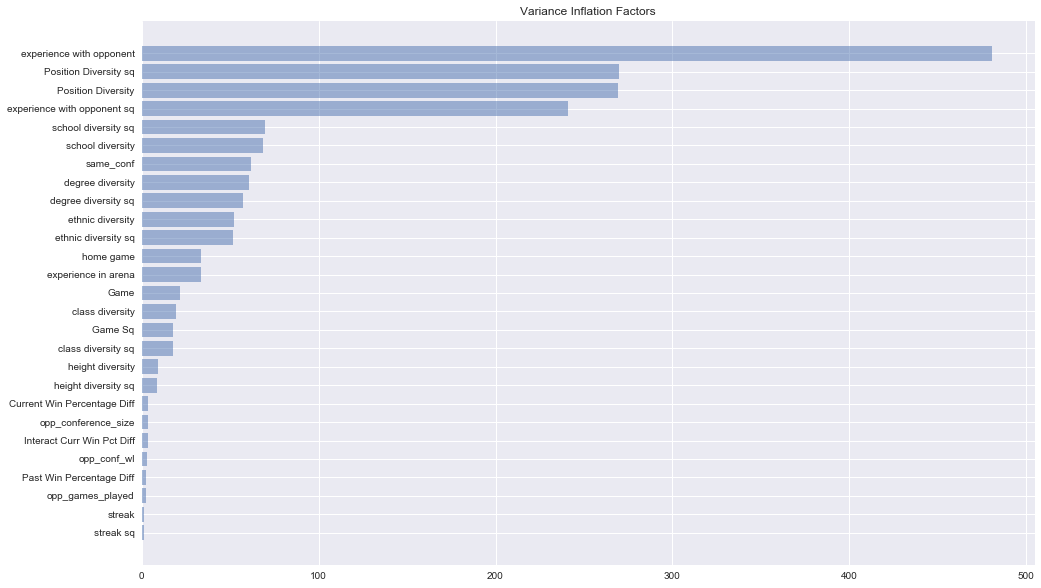

In [14]:
plt.figure(figsize = (16, 10))
plt.barh(np.arange(len(vifVar)), np.array(vifVar)[idxVifSorted], align = 'center', alpha = 0.5)
plt.yticks(np.arange(len(vifVar)), np.array(predictors)[idxVifSorted], rotation = 0)
plt.title("Variance Inflation Factors")
plt.show()
plt.close()

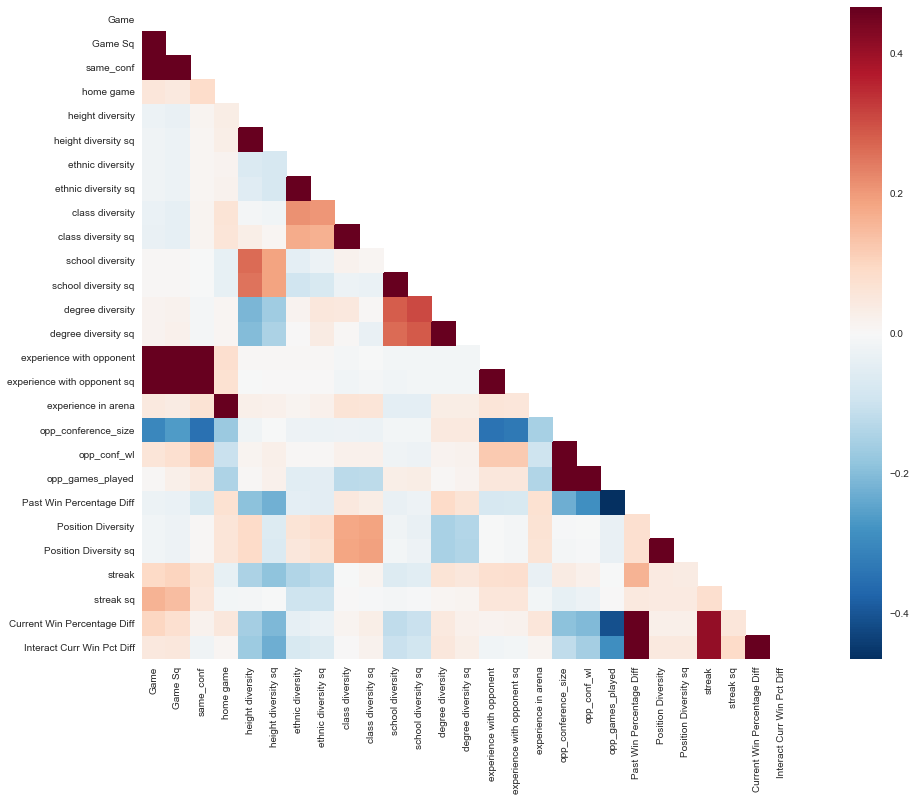

In [15]:
sns.set(style = "white")
collegeBballCorr = collegeBball[predictors].corr()

f2 = plt.figure(figsize = (20, 12))
mask = np.zeros_like(collegeBballCorr)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    sns.heatmap(collegeBballCorr, mask = mask, vmax = .3, square = True)
plt.xticks(rotation = 90)
plt.yticks(rotation = 0)
plt.show()
plt.close()

In [16]:
def random_forest_func(df, predictors, targets, test_size = 0.3):

    #Split into training and testing sets
    x = df[predictors]
    y = df[targets]
    pred_train, pred_test, tar_train, tar_test  = train_test_split(x, y, test_size = test_size)    
    
    #Build model on training data  
    classifier = GridSearchCV(RandomForestClassifier(n_estimators = 100), param_grid = {"min_samples_leaf": [1, 5, 10, 40]}, 
                              cv = 10)
    #classifier = RandomForestClassifier(n_estimators = 100)
    classifier = classifier.fit(pred_train,tar_train)
    
    # fit an Extra Trees model to the data
    model = GridSearchCV(ExtraTreesClassifier(n_estimators = 100), param_grid = {"min_samples_leaf": [1, 5, 10, 40]}, cv = 10)
    #model = ExtraTreesClassifier(n_estimators = 100)
    model.fit(pred_train,tar_train)
    
    #getting the training and test accuracies from random forest classifier
    #train_accuracy
    predictions = classifier.predict(pred_train)
    train_accuracy = sklearn.metrics.accuracy_score(tar_train, predictions)
    #test_accuracy
    predictions = classifier.predict(pred_test)
    test_accuracy = sklearn.metrics.accuracy_score(tar_test, predictions)
    
    # display the relative importance of each attribute from extra trees classifier
    feature_importance = model.best_estimator_.feature_importances_
    #feature_importance = model.feature_importances_

    return feature_importance, train_accuracy, test_accuracy


In [17]:
importance, train_accuracy, test_accuracy = random_forest_func(collegeBball, predictors, target)

print("Random Forest Test Set Accuracy: %.4f" % test_accuracy)

Random Forest Test Set Accuracy: 0.6847


In [18]:
idxSorted = sorted(range(len(importance)), key = lambda k: importance[k], reverse = False)

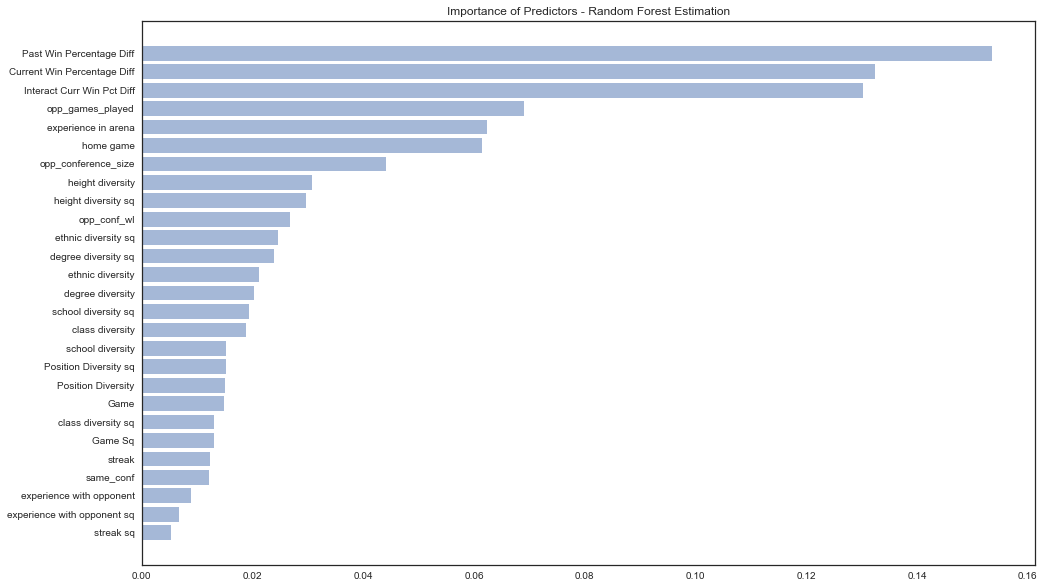

In [19]:
plt.figure(figsize = (16, 10))
plt.barh(np.arange(len(importance)), importance[idxSorted], align = 'center', alpha = 0.5)
plt.yticks(np.arange(len(importance)), np.array(predictors)[idxSorted], rotation = 0)
plt.title("Importance of Predictors - Random Forest Estimation")
plt.show()
plt.close()

In [20]:
def logit_reg_func(df, predictors, target, test_size = 0.3, random_state = 123):
    perf = []

    # standardize variables
    x = preprocessing.scale(df[predictors].copy())
    y = df[target]    
    
    # split data into train and test sets
    pred_train, pred_test, tar_train, tar_test = train_test_split(x, 
                                                                  y, 
                                                                  test_size = test_size, 
                                                                  random_state = random_state)
    
    # specify the logistic regression model with L1 regularization
    model = LogisticRegressionCV(cv = 10, penalty='l1', solver = 'liblinear').fit(pred_train,tar_train)
    
    # Accuracy Score from training and test data
    rsquared_train=model.score(pred_train,tar_train)
    rsquared_test=model.score(pred_test,tar_test)
    perf.append(('training data accuracy', rsquared_train))
    perf.append(('test data accuracy', rsquared_test))
    
    # Return variable names & coefficients, as well as training and test performance
    return dict(zip(predictors, model.coef_.flatten())), perf

In [21]:
logitRegCoef, logitRegPerf = logit_reg_func(collegeBball, predictors, target)

In [22]:
for (name, metric) in logitRegPerf:
    print("L1-Regularised Logit %s: %.4f" % (name, metric))

L1-Regularised Logit training data accuracy: 0.6950
L1-Regularised Logit test data accuracy: 0.7061


In [23]:
coefImptDF = pd.DataFrame.from_dict(logitRegCoef, orient = 'index')
coefImptDF.columns = ['Coefficient']
coefImptDF

,Coefficient
streak,0.000000
opp_games_played,-0.074608
opp_conference_size,-0.287575
Interact Curr Win Pct Diff,0.369325
Position Diversity sq,0.000000
school diversity,0.000000
Past Win Percentage Diff,0.500329
Current Win Percentage Diff,0.000000
degree diversity,0.000000
degree diversity sq,0.000000


In [24]:
coefNames = coefImptDF.index.values
absCoefVals = np.abs(coefImptDF['Coefficient'].values)
idxCoefSorted = sorted(range(len(absCoefVals)), key = lambda k: absCoefVals[k], reverse = False)

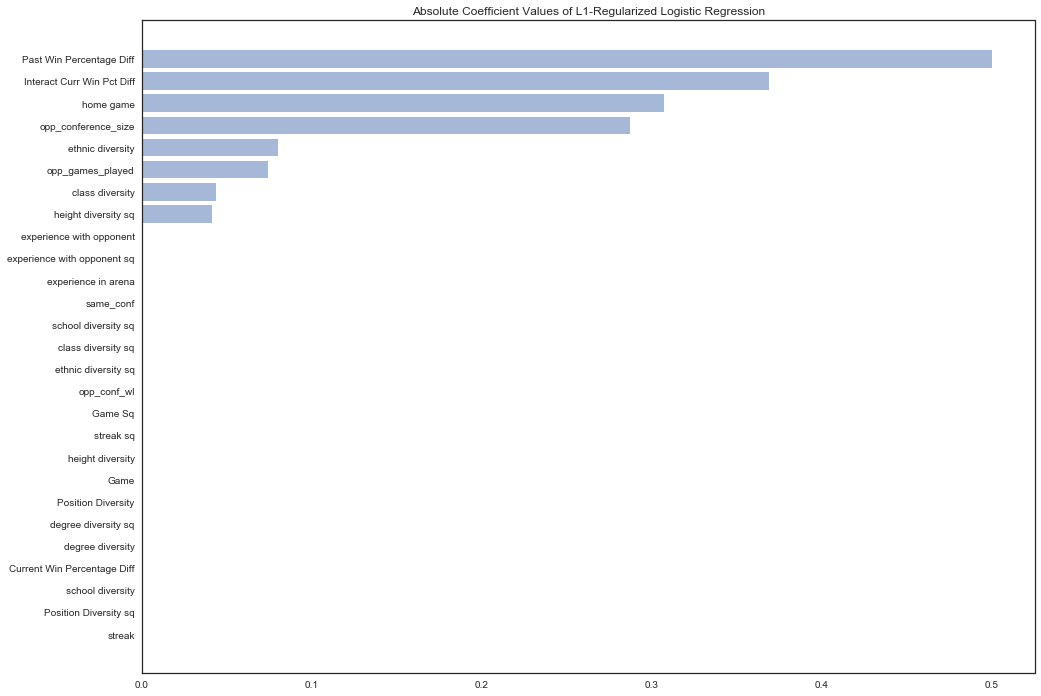

In [25]:
plt.figure(figsize = (16, 12))
plt.barh(np.arange(len(absCoefVals)), absCoefVals[idxCoefSorted], align = 'center', alpha = 0.5)
plt.yticks(np.arange(len(absCoefVals)), coefNames[idxCoefSorted], rotation = 0)
plt.title("Absolute Coefficient Values of L1-Regularized Logistic Regression")
plt.show()
plt.close()

### Part 4: Model Interpretation

In [44]:
reducedPredictors = ['Game', 'home game', 'height diversity', 'height diversity sq', 'ethnic diversity',  'class diversity', 
                     'school diversity', 'degree diversity', 'experience with opponent', 'opp_conference_size', 
                     'opp_games_played', 'Past Win Percentage Diff', 'Position Diversity', 'streak', 'streak sq', 
                     'Current Win Percentage Diff', 'Interact Curr Win Pct Diff']


In [45]:
# Calculate Variance Inflation Factors for each variables
vifReduced = [variance_inflation_factor(add_constant(collegeBball[reducedPredictors]).as_matrix(), i) for i in \
              range(add_constant(collegeBball[reducedPredictors]).shape[1])]

# Print out the VIF values
pd.DataFrame(data = {'VAR': ['const'] + reducedPredictors, 'VIF': vifReduced}).round(2)

,VAR,VIF
0,const,275.38
1,Game,2.78
2,home game,1.05
3,height diversity,8.21
4,height diversity sq,7.78
5,ethnic diversity,1.10
6,class diversity,1.11
7,school diversity,1.32
8,degree diversity,1.26
9,experience with opponent,2.92


In [28]:
logit = sm.Logit(collegeBball[target].astype(int), add_constant(collegeBball[reducedPredictors]))
result = logit.fit()
print(result.summary())

oddsr = np.exp(result.params)
pvals = result.pvalues

Optimization terminated successfully.
         Current function value: 0.567375
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                    win   No. Observations:                 2334
Model:                          Logit   Df Residuals:                     2316
Method:                           MLE   Df Model:                           17
Date:                Fri, 09 Jun 2017   Pseudo R-squ.:                  0.1809
Time:                        15:51:30   Log-Likelihood:                -1324.3
converged:                       True   LL-Null:                       -1616.6
                                        LLR p-value:                2.399e-113
                                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------
const                           3.1262      0.853      3.664      0.000   

In [29]:
# Accuracy Score
temp = result.predict(add_constant(collegeBball[reducedPredictors]))
temp
truth = collegeBball['win'].astype(int).values
print("In-Sample Accuracy: %.4f" % (np.sum(abs(truth - temp) < 0.5) / collegeBball.shape[0]))

In-Sample Accuracy: 0.7005


#### Visualising the Effects of Significant Predictors on Odd of Winning the Game

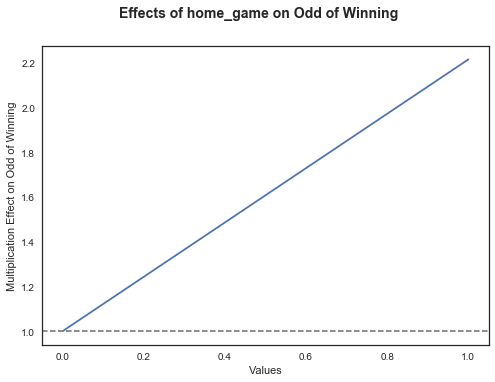

In [30]:
def graph(formula, x_range, plt_title):  
    x = np.array(x_range)  
    y = eval(formula)
    fig = plt.figure()
    fig.suptitle(plt_title, fontsize=14, fontweight='bold')
    plt.plot(x, y) 
    plt.axhline(1.0, color = 'grey', ls = 'dashed')
    plt.ylabel("Multiplication Effect on Odd of Winning")
    plt.xlabel("Values")
    plt.show()
    
# home_game
size_formula = 'np.exp(0.7946*x)'
size_range =  range(2) # range is 0 and 1
graph(size_formula, size_range, 'Effects of home_game on Odd of Winning')

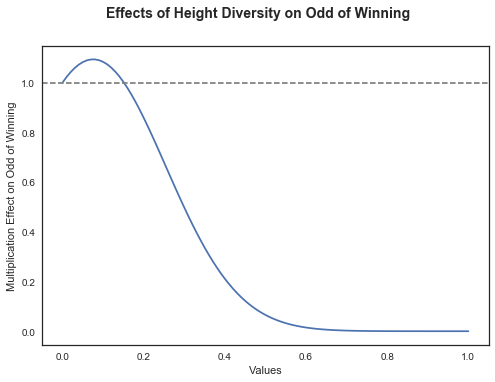

In [31]:
# height diversity
size_formula = 'np.exp(2.3611*x - 15.6314*(x**2))'
size_range = np.arange(0, 1.01, 0.01)
graph(size_formula, size_range, 'Effects of Height Diversity on Odd of Winning')

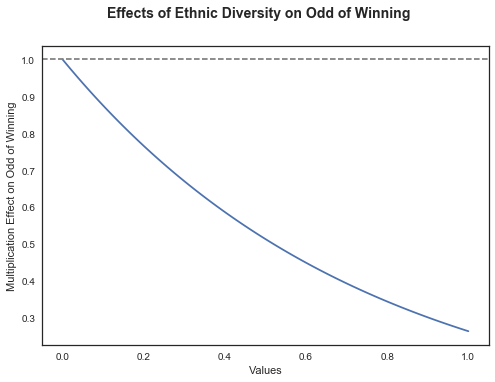

In [32]:
# ethnic diversity
size_formula = 'np.exp(-1.3356*x)'
size_range = np.arange(0, 1.01, 0.01)
graph(size_formula, size_range, 'Effects of Ethnic Diversity on Odd of Winning')

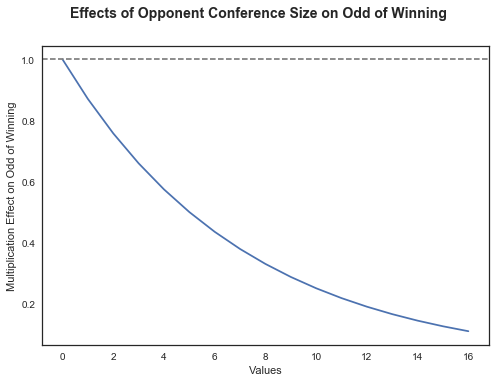

In [33]:
# opp_conference_size
size_formula = 'np.exp(-0.1390*x)'
size_range = np.arange(0, 17, 1) # Max Conference Size is 16
graph(size_formula, size_range, 'Effects of Opponent Conference Size on Odd of Winning')

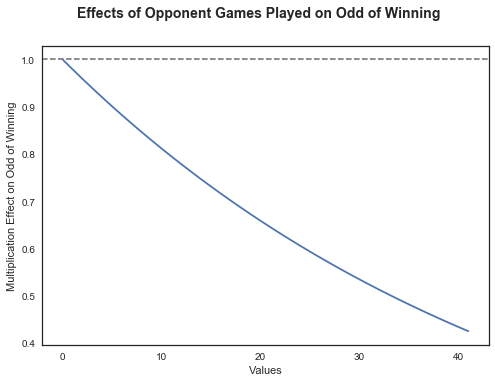

In [34]:
# opp_games_played
size_formula = 'np.exp(-0.0209*x)'
size_range = np.arange(0, 42, 1) # Max Opponent Games Played is 41
graph(size_formula, size_range, 'Effects of Opponent Games Played on Odd of Winning')

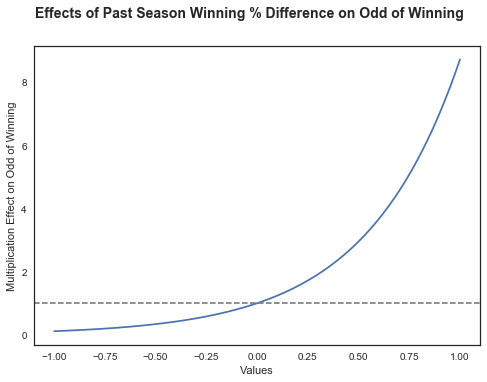

In [35]:
# Past Season Win % Difference
size_formula = 'np.exp(2.1650*x)'
size_range = np.arange(-1, 1.01, 0.01)
graph(size_formula, size_range, 'Effects of Past Season Winning % Difference on Odd of Winning')

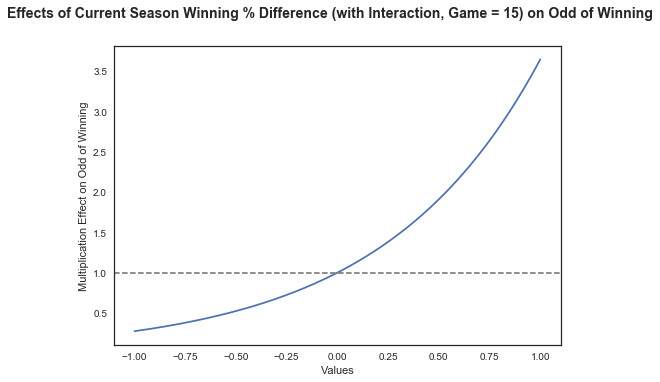

In [36]:
# Game x (Current Season Win % Difference)
# Examine the effect of (Current Season Win % Difference) when Game = 15 (mean)
size_formula = 'np.exp(0.0862*15*x)'
size_range = np.arange(-1, 1.01, 0.01)
graph(size_formula, size_range, 'Effects of Current Season Winning % Difference (with Interaction, Game = 15) on Odd of Winning')

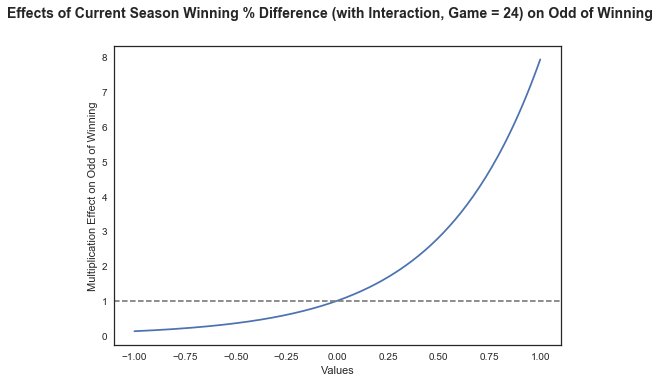

In [37]:
# Game x (Current Season Win % Difference)
# Examine the effect of (Current Season Win % Difference) when Game = 24 (mean + 1 std dev)
size_formula = 'np.exp(0.0862*24*x)'
size_range = np.arange(-1, 1.01, 0.01)
graph(size_formula, size_range, 'Effects of Current Season Winning % Difference (with Interaction, Game = 24) on Odd of Winning')

### Appendix: Mean, Standard Deviation, Max and Min of Predictors Data

In [38]:
collegeBball[reducedPredictors].mean(axis = 0)

Game                           15.138389
home game                       0.404884
height diversity                0.101826
height diversity sq             0.016359
ethnic diversity                0.512051
class diversity                 0.238977
school diversity                0.434569
degree diversity                0.581354
experience with opponent        1.494430
opp_conference_size             9.017995
opp_games_played               28.611825
Past Win Percentage Diff        0.019831
Position Diversity              0.553279
streak                         -0.032991
streak sq                       8.579692
Current Win Percentage Diff    -0.002464
Interact Curr Win Pct Diff      0.218675
dtype: float64

In [39]:
collegeBball[reducedPredictors].std(axis = 0)

Game                            8.509653
home game                       0.490975
height diversity                0.077412
height diversity sq             0.018353
ethnic diversity                0.136586
class diversity                 0.255896
school diversity                0.073076
degree diversity                0.146806
experience with opponent        0.515274
opp_conference_size             2.830036
opp_games_played                7.129574
Past Win Percentage Diff        0.261807
Position Diversity              0.046557
streak                          2.929553
streak sq                      17.792834
Current Win Percentage Diff     0.305741
Interact Curr Win Pct Diff      4.564992
dtype: float64

In [40]:
collegeBball[reducedPredictors].max(axis = 0)

Game                            34.000000
home game                        1.000000
height diversity                 0.304688
height diversity sq              0.092834
ethnic diversity                 0.768166
class diversity                  0.746667
school diversity                 0.500000
degree diversity                 0.755556
experience with opponent         3.000000
opp_conference_size             16.000000
opp_games_played                41.000000
Past Win Percentage Diff         0.844000
Position Diversity               0.648438
streak                          16.000000
streak sq                      256.000000
Current Win Percentage Diff      1.000000
Interact Curr Win Pct Diff      22.733333
dtype: float64

In [41]:
collegeBball[reducedPredictors].min(axis = 0)

Game                            1.000000
home game                       0.000000
height diversity                0.000000
height diversity sq             0.000000
ethnic diversity                0.218750
class diversity                 0.000000
school diversity                0.132653
degree diversity                0.124444
experience with opponent        1.000000
opp_conference_size             0.000000
opp_games_played                0.000000
Past Win Percentage Diff       -0.773000
Position Diversity              0.408163
streak                        -13.000000
streak sq                       0.000000
Current Win Percentage Diff    -0.923000
Interact Curr Win Pct Diff    -16.682815
dtype: float64